In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")


In [18]:
# Load dataset
train_data = pd.read_csv('Titanic_train.csv')
test_data = pd.read_csv('Titanic_test.csv')

In [19]:
def eda(data):
    print("Data Overview:\n", data.head())
    print("\nMissing Values:\n", data.isnull().sum())
    print("\nSummary Statistics:\n", data.describe())
     # Visualizing distributions
    sns.histplot(data['Age'].dropna(), bins=30, kde=True)
    plt.title("Age Distribution")
    plt.show()

    # Box plot for fare
    sns.boxplot(x=data['Fare'])
    plt.title("Fare Distribution")
    plt.show()

    # Bar plot for survival
    sns.countplot(x='Survived', data=data)
    plt.title("Survival Count")
    plt.show()


In [20]:
def preprocess_data(data):
    # Impute missing values
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

    # Encode categorical variables
    label_enc = LabelEncoder()
    for col in ['Sex', 'Embarked']:
        data[col] = label_enc.fit_transform(data[col])

    # Drop constant or near-constant features
    data = data.loc[:, data.nunique() > 1]

    # Select features
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    return data[features], data['Survived']


Data Overview:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   N

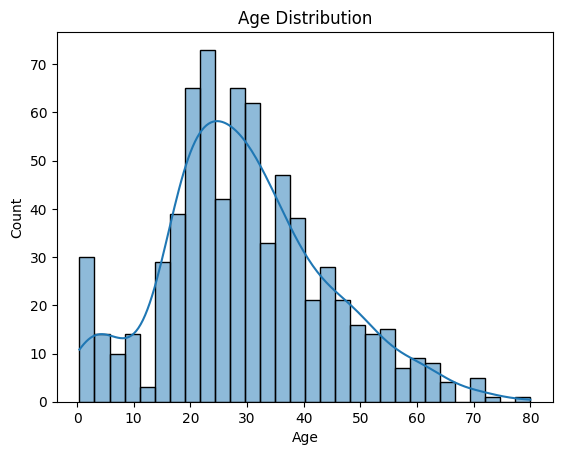

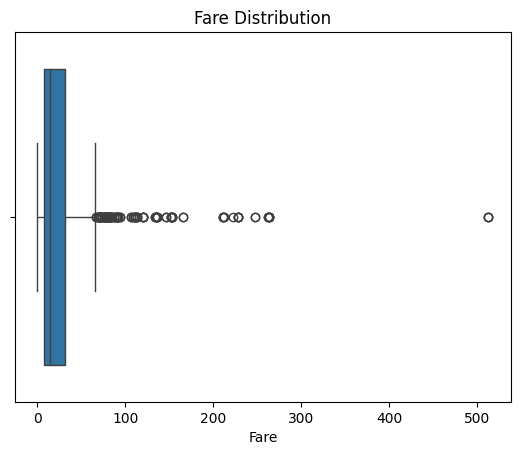

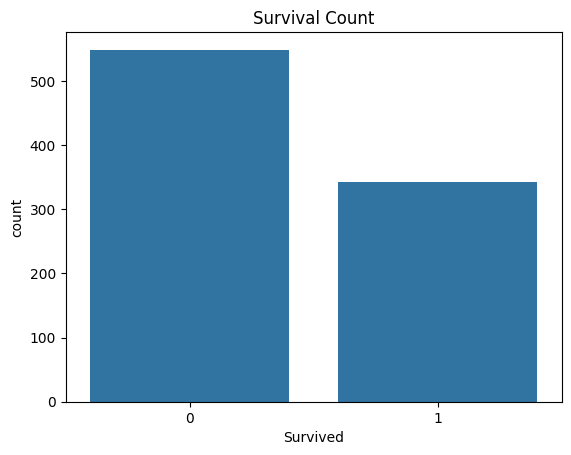

In [21]:
# Run EDA
eda(train_data)

In [22]:
# Preprocess Data
X, y = preprocess_data(train_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# Train LightGBM Model
lgb_model = lgb.LGBMClassifier(min_data_in_leaf=20, num_leaves=50)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [24]:
# Train XGBoost Model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [25]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

evaluate_model(y_test, y_pred_lgb, "LightGBM")
evaluate_model(y_test, y_pred_xgb, "XGBoost")



LightGBM Performance:
Accuracy: 0.8212
Precision: 0.7838
Recall: 0.7838
F1 Score: 0.7838

XGBoost Performance:
Accuracy: 0.7877
Precision: 0.7368
Recall: 0.7568
F1 Score: 0.7467


In [26]:

# Visualization
models = ['LightGBM', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [
    [accuracy_score(y_test, y_pred_lgb), precision_score(y_test, y_pred_lgb), recall_score(y_test, y_pred_lgb), f1_score(y_test, y_pred_lgb)],
    [accuracy_score(y_test, y_pred_xgb), precision_score(y_test, y_pred_xgb), recall_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_xgb)]
]

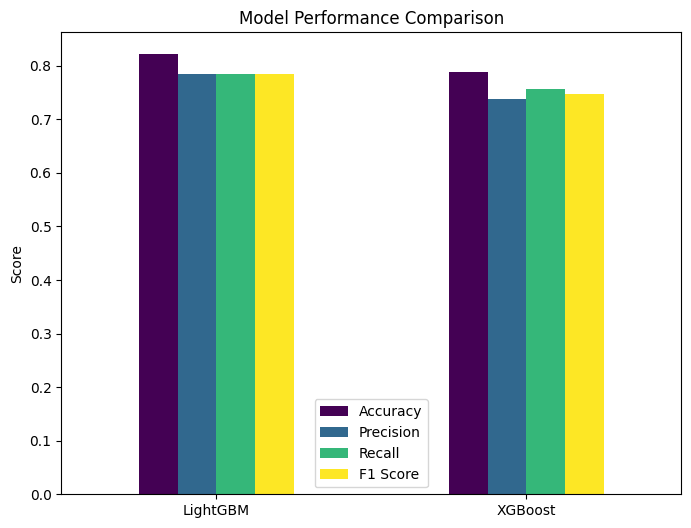

In [27]:

scores_df = pd.DataFrame(scores, columns=metrics, index=models)
scores_df.plot(kind='bar', figsize=(8,6), colormap='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

In [28]:
!pip install lightgbm xgboost

